In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [19]:
from src.llms.class_model import LLMParams, LLM
from src.llms.service import generate

In [7]:
blog_url = 'https://a16z.com/emerging-architectures-for-llm-applications/'
reader_url = 'https://fun-readable-cd6ed9e43b50.herokuapp.com/convert'
import requests

res = requests.post(reader_url, json={'url': blog_url, 'is_blog': True})
res.status_code

200

In [8]:
article = res.json()['text']
print(article[:100])


Large language models are a powerful new primitive for building software. But since they are so new


In [9]:
article = article.strip()
print(article[:100])

Large language models are a powerful new primitive for building software. But since they are so new—


# Preprocessing Text

In [10]:
from src import utils
from nltk.tokenize import sent_tokenize

In [12]:
text = article
# split into sentences
sentences = sent_tokenize(text)
# further split by comma
segments = [sent.split(',') for sent in sentences]
# flaten
segments = [x for sent in segments for x in sent]

sentences = utils.create_sentences(segments, MIN_WORDS=20, MAX_WORDS=80)
chunks = utils.create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
chunks_text = [chunk['text'] for chunk in chunks]

In [13]:
len(chunks_text)

24

# Summarize stage 1

In [17]:
import os

# llm configs
together_api_url = "https://api.together.xyz/v1/completions"
together_api_key = os.environ['TOGETHER_API_KEY']

openai_api_url = "https://api.openai.com/v1/chat/completions"
openai_api_key = os.environ['OPENAI_API_KEY']

### GPT 4

In [14]:
gpt_prompt = (
  '{text}\n'
  '---\n'
  'Summarize the above in one sentence and give title.\n'
  'Respond in the following format:\n'
  'Title | Summary\n'
  'eg. Why Artificial Intelligence is Good |  AI can make humans more productive by automating many repetitive processes.\n'
  'Response:\n'
)

In [16]:
gpt_4_params = LLMParams(
  max_tokens=300,
  temperature=0.5,
  top_p=0.9,
  top_k=50,
  stop=['\n']
)

In [18]:
gpt_4 = LLM(
  url=openai_api_url,
  api_key=openai_api_key,
  model='gpt-4-turbo-preview',
  llm_params=gpt_4_params,
  prompt_template=gpt_prompt
)

In [20]:
inputs = [[{'text': chunk_txt}] for chunk_txt in chunks_text]
llms = [gpt_4]
outputs = generate(inputs, llms, max_retries=2, total_timeout=20)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [25]:
def parse_title_summary_results(output):
  title, summary = None, None
  if '|' in output:
    title, summary = output.split('|')
    title, summary = title.strip(), summary.strip()
  elif ':' in output:
    title, summary = output.split(':')
    title, summary = title.strip(), summary.strip()

  return dict(title=title, summary=summary)

In [27]:
from tqdm.notebook import tqdm

In [28]:
stage_1_outputs = []
for inp in tqdm(chunks_text):
  _ = gpt_4.generate({'text': inp})
  res = gpt_4.get_text_from_response()
  x = parse_title_summary_results(res)
  stage_1_outputs.append(x)



  0%|          | 0/24 [00:00<?, ?it/s]

/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/re/__init__.py:258: RuntimeWarning: coroutine '_generate' was never awaited
  return pattern.translate(_special_chars_map)


KeyboardInterrupt: 

### Nous Hermes Mixtral


###### config

```python
nous_hermes_mixtral_prompt = (
  '<|im_start|>system\n'
  'Summarize the above in one sentence and give title.\n'
  'Respond in the following JSON format:\n'
  '{\n  "summary": <summary of the text>",\n  "title": <short title for the summary>\n}\n'
  'eg.\n{\n  "summary": "AI can make humans more productive by automating many repetitive processes.",\n  "title": "Why Artificial Intelligence is Good"\n}\n'
  '<|im_start|>human\n'
  '\'\'\'text\n'
  '{{ text }}\n'
  '\'\'\'<|im_end|>\n'
  '<|im_start|>assistant\n'
)
print('final_prompt:', nous_hermes_mixtral_prompt)
env = jinja2.Environment()
nous_hermes_mixtral_prompt = env.from_string(nous_hermes_mixtral_prompt)

nous_hermes_mixtral_params = LLMParams(
  max_tokens=300,
  temperature=0.5,
  top_p=0.9,
  top_k=50,
  stop=['<|im_end|>']
)


nous_hermes_mixtral = LLM(
  url=together_api_url,
  api_key=together_api_key,
  model='NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO',
  llm_params=nous_hermes_mixtral_params,
  prompt_template=nous_hermes_mixtral_prompt
)

def parse_title_summary_results(ai_response: str):
  start_idx = ai_response.find('{')
  end_idx = ai_response.rfind('}') + 1
  return json.loads(ai_response[start_idx:end_idx])
```

#### encoding

In [30]:
import pickle

with open('nous_hermes_mixtral_stage_1_summary_embeddings.pkl', 'rb') as f:
  summary_embeds = pickle.load(f)

type(summary_embeds)

numpy.ndarray

In [31]:
summary_similarity_matrix = utils.cosine_similarity(summary_embeds, summary_embeds)

In [33]:
import dotenv
dotenv.load_dotenv('../.dev.env')

True

/opt/homebrew/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


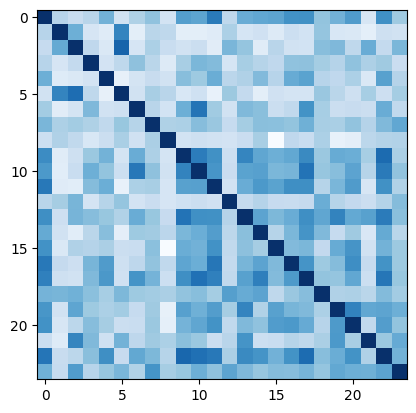

In [34]:
import main

main.save_similarity_matrix_plot(summary_similarity_matrix, 'nous_hermes_mixtral_stage_1_summary_similarity_matrix.png')

In [37]:
import numpy as np

# Function to sort the similarity matrix
def sort_similarity_matrix(matrix):
    # Get the sorted indices based on the sum of similarities in each row
    sorted_indices = np.argsort(np.sum(matrix, axis=1))
    # Rearrange the rows and columns of the matrix based on the sorted indices
    sorted_matrix = matrix[sorted_indices][:, sorted_indices]
    return sorted_matrix

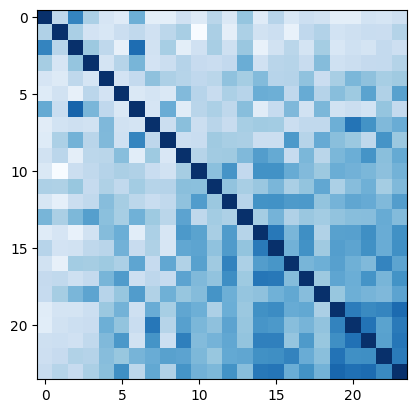

In [38]:
summary_similarity_matrix_sorted = sort_similarity_matrix(summary_similarity_matrix)
main.save_similarity_matrix_plot(summary_similarity_matrix_sorted, 'nous_hermes_mixtral_stage_1_summary_similarity_matrix_sorted.png')

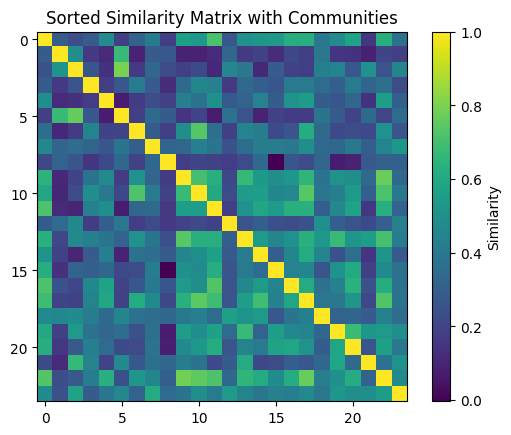

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Generate a sample similarity matrix (replace this with your actual similarity matrix)
similarity_matrix = summary_similarity_matrix

# Convert similarity matrix to a graph
G = nx.from_numpy_array(similarity_matrix)

# Apply the Louvain algorithm for community detection
partition = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

# Create a dictionary to store community assignments
community_dict = {}
for i, community in enumerate(partition):
    for node in community:
        community_dict[node] = i

# Sort nodes based on community assignments
sorted_nodes = sorted(G.nodes(), key=lambda x: community_dict[x])

# Reorder the similarity matrix based on community assignments
sorted_similarity_matrix = similarity_matrix[sorted_nodes][:, sorted_nodes]

# Plot the sorted similarity matrix
plt.imshow(sorted_similarity_matrix, interpolation='none')
plt.colorbar(label='Similarity')
plt.title('Sorted Similarity Matrix with Communities')
plt.show()


Best SD: inf, Best iteration: 0


In [57]:
len(summary_embeds)

24

Best SD: 1.1547005383792515, Best iteration: 0


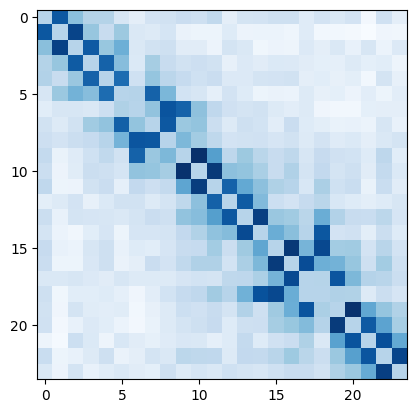

In [58]:
import math

topics_out = utils.get_topics(summary_similarity_matrix, num_topics=math.ceil(len(summary_embeds)/4), bonus_constant=0.2)
s_ids = []
for topic in topics_out['topics']:
  s_ids.extend(topic)

summary_similarity_matrix_sorted = summary_similarity_matrix[s_ids][:, s_ids]
main.save_similarity_matrix_plot(summary_similarity_matrix_sorted, 'nous_hermes_mixtral_stage_1_summary_similarity_matrix_sorted_topics.png')